# Song recommender

## imports

In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np

import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
from requests.exceptions import ReadTimeout
from IPython.display import IFrame, display
import config

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from matplotlib import pyplot
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
%matplotlib inline

from time import sleep
from random import randint


## 1. Top 100

In [2]:
# extract song names from top 100
def get_songs(containers):
    songs = []
    i = 0
    while i < len(containers):
        song = containers[i].find('h3').get_text()
        songs.append(song.replace('\n', '').replace('\t', ''))
        i += 1
    return songs


In [3]:
# extract artists from top 100
def get_artists(containers):
    artists = []
    i = 0
    while i < len(containers):
        artist = containers[i].find(
            'span', {'class': 'a-no-trucate'}).get_text()
        artists.append(artist.replace('\n', '').replace('\t', ''))
        i += 1
    return artists


## 2. Spotify API

In [4]:
sp = spotipy.Spotify(auth_manager=SpotifyClientCredentials(client_id=config.client_id,
                                                           client_secret=config.client_secret), 
                                                           requests_timeout=10, 
                                                           retries=10)


In [5]:
# get playlist tracks
def get_tracks(playlist_id):
    results = sp.user_playlist_tracks('spotify', playlist_id, market="GB")
    tracks = results['items']
    while results['next']:
        results = sp.next(results)
        tracks.extend(results['items'])
        #sleep(20)
    return tracks


In [6]:
# extract song ids
def extract_ids(playlist):
    ids = []
    i = 0
    while i < len(playlist):
        ids.append(playlist[i]['track']['id'])
        i += 1
    return ids


In [7]:
# extract song features for each id
def extract_features(ids):
    features_by_id = []
    i = 0

    while i < len(ids):
        try:
            if sp.audio_features(ids[i])[0]:
                features_by_id.append(sp.audio_features(ids[i])[0])
        except TypeError:
            continue
        except AttributeError:
            continue
        finally:
            i += 1

    return features_by_id


In [8]:
# Features to data frame
def to_df(playlist_id):
    playlist = get_tracks(playlist_id)
    ids = extract_ids(playlist)
    features = extract_features(ids)

    df = pd.DataFrame(features)
    #df = pd.concat([df['id'], df.drop(['id'], axis=1)], axis=1)
    df.drop(['type', 'uri', 'track_href', 'analysis_url', 'time_signature', 'duration_ms'], axis=1, inplace=True)
    
    return df


In [9]:

# p1 - 5S8SJdl1BDc0ugpkEvFsIL - 10k 
# p2 - 7beGd4yYY1qpsBv6K3clFZ - 4.5k
# p3 - 69fEt9DN5r4JQATi52sRtq - 6k
# p4 - 6ajZ3ZK5HL1peecsWjWZ7Y - 8.6k
# p5 - 0NnLQDJODqRGP83SP7VCEg - 4k
# p6 - 2xprAOAO0bPjec45puo08f - 1k
# p7 - 6srddMK48bjlvaVZBpukVv - 1.3k
# p8 - 1C49yxU1XBkoq5yaVDbJwx - 8.2k

# p1 = pd.read_csv('p1.csv')
# p2 = pd.read_csv('p2.csv')
# p3 = pd.read_csv('p3.csv')
# p4 = pd.read_csv('p4.csv')
# p5 = pd.read_csv('p5.csv')
# p6 = pd.read_csv('p6.csv')
# p7 = pd.read_csv('p7.csv')
# p8 = pd.read_csv('p8.csv')

# df = pd.concat([p1, p2, p3, p4, p5, p6, p7, p8], ignore_index=True)
# df.drop_duplicates(inplace=True, ignore_index=True)
# df.to_csv('data.csv', index=False)

df = pd.read_csv('data.csv')

## 3. Clustering

In [10]:
# data frama of scaled features
def get_scaled_features(df):
    features = df.drop(['id'], axis=1)
    scaler = StandardScaler()
    scaler.fit(features)

    features_scaled = scaler.transform(features)
    features_scaled_df = pd.DataFrame(features_scaled, columns=features.columns)

    return features_scaled_df



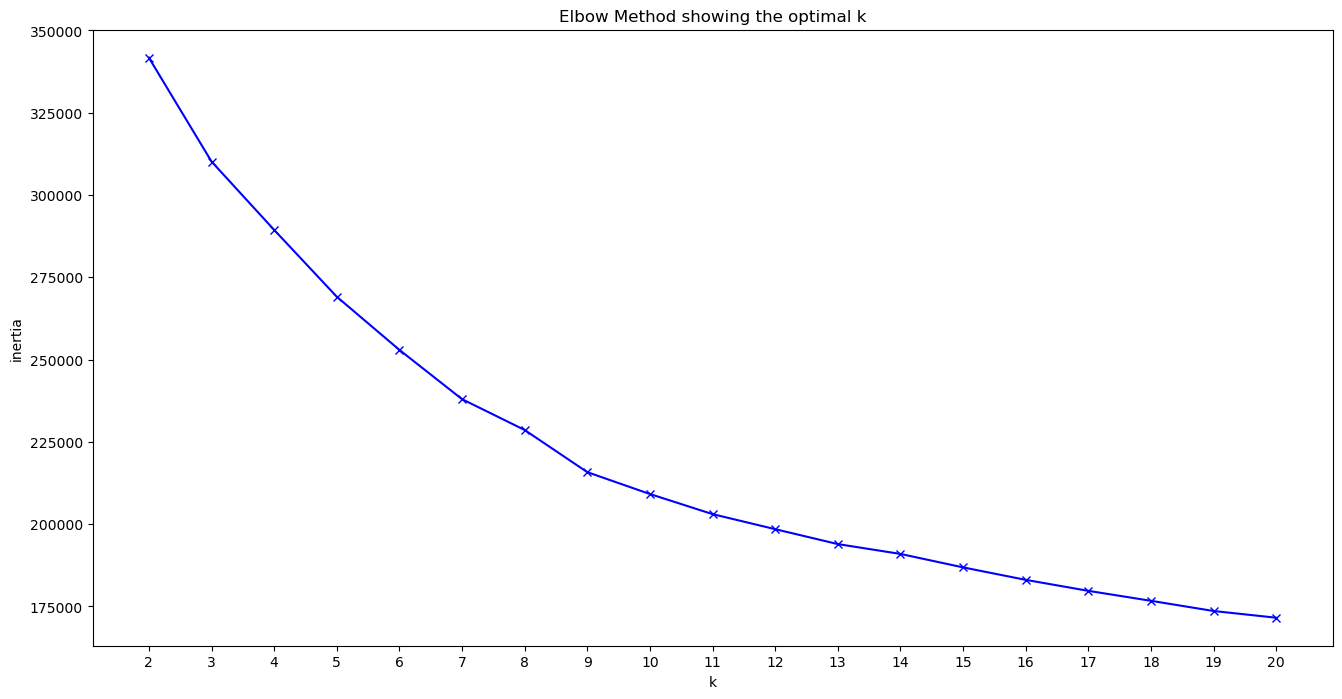

In [11]:
# draw plot for elbow method
def draw_elbow(scaled_features):
    cluster_range = range(2, 21)
    inertia = []

    for i in cluster_range:
        kmeans = KMeans(n_clusters=i, random_state=1234)
        kmeans.fit(scaled_features)
        inertia.append(kmeans.inertia_)

    plt.figure(figsize=(16, 8))
    plt.plot(cluster_range, inertia, 'bx-')
    plt.xlabel('k')
    plt.ylabel('inertia')
    plt.xticks(np.arange(min(cluster_range), max(cluster_range)+1, 1.0))
    plt.title('Elbow Method showing the optimal k')
    

scaled_features = get_scaled_features(df)
draw_elbow(scaled_features)  # k = 8-9

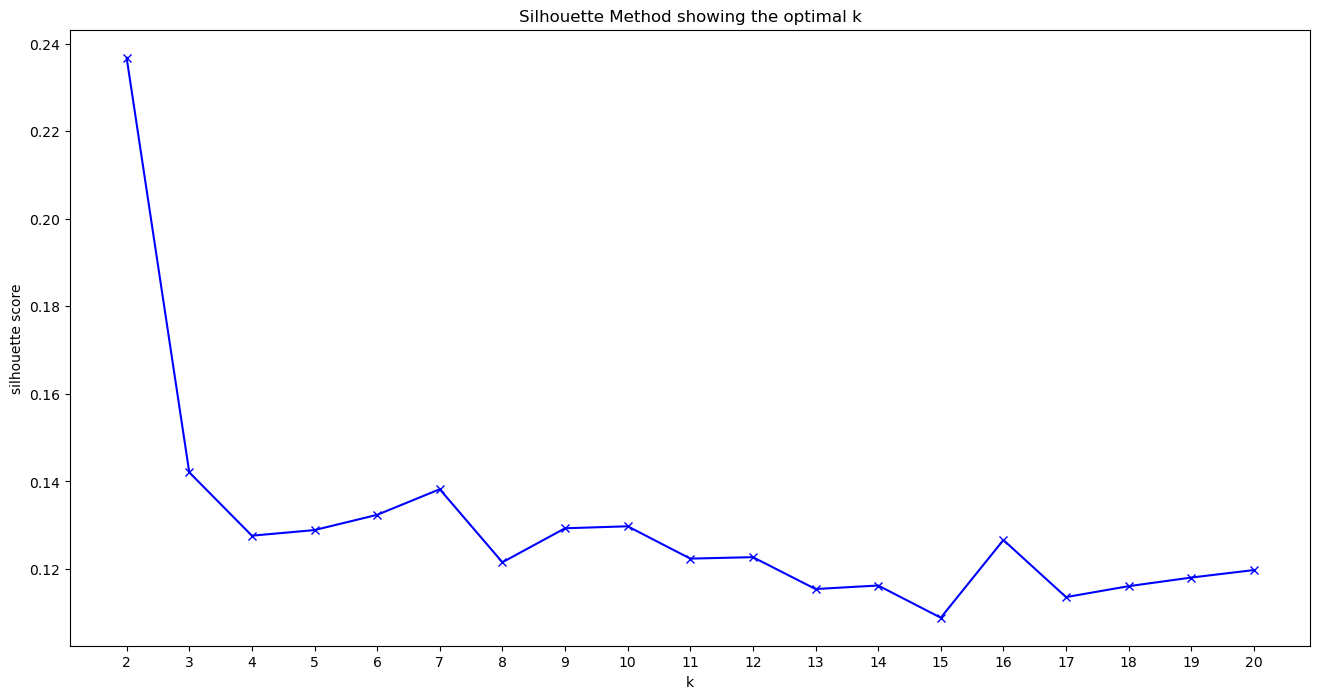

In [12]:
# draw plot for silhouette method
def draw_silhouette(scaled_features):
    cluster_range = range(2, 21)
    silhouette = []

    for i in cluster_range:
        kmeans = KMeans(n_clusters=i, random_state=1234)
        kmeans.fit(scaled_features)

        clusters = kmeans.predict(scaled_features)
        silhouette.append(silhouette_score(scaled_features, clusters))

    plt.figure(figsize=(16,8))
    plt.plot(cluster_range, silhouette, 'bx-')
    plt.xlabel('k')
    plt.ylabel('silhouette score')
    plt.xticks(np.arange(min(cluster_range), max(cluster_range)+1, 1.0))
    plt.title('Silhouette Method showing the optimal k')


scaled_features = get_scaled_features(df)
draw_silhouette(scaled_features)    # k = 3/8

In [13]:
def clustering(k, scaled_features):
    kmeans = KMeans(n_clusters=k, random_state=1234)
    kmeans.fit(scaled_features)

    clusters = kmeans.predict(scaled_features)

    return clusters


## 4. Recommender

In [14]:
# song's features
def song_features_df(id):
    features = sp.audio_features(id)[0]
    features = pd.DataFrame(features, index=[0])
    features.drop(['type', 'uri', 'track_href', 'analysis_url', 'time_signature', 'duration_ms'], 
            axis=1, inplace=True)
    
    return features


In [15]:
# player iframe
def player(track_id):
    iframe = IFrame(src="https://open.spotify.com/embed/track/"+track_id,
                    width="320",
                    height="80",
                    frameborder="0",
                    allowtransparency="true",
                    allow="encrypted-media",)
    
    return iframe

In [16]:
## dfs

# top100 df
url = 'https://www.billboard.com/charts/hot-100/'
res = requests.get(url)

soup = BeautifulSoup(res.text, 'html.parser')
top100 = soup.find_all('div', {'class': 'o-chart-results-list-row-container'})

artists = get_artists(top100)
songs = get_songs(top100)

top100_df = pd.DataFrame(zip(artists, songs), columns=['Artist', 'Song'])
top100_df.index = np.arange(1, len(top100_df) + 1)


# spotify playlists
df = pd.read_csv('data.csv')

scaled_features = get_scaled_features(df)
clusters = clustering(8, scaled_features)
df['cluster'] = clusters



In [17]:
def recommender(top100_df, spotify_df, scaled_features):
    #input
    artist = input('Artist name: ').lower()
    song = input('Song name: ').lower()
    track = f'{artist} {song}'
    
    #spotify search
    search_res = sp.search(q=track, limit=1,market="GB")
    search_id = search_res['tracks']['items'][0]['id']
    search_artist = search_res['tracks']['items'][0]['artists'][0]['name']
    search_song = search_res['tracks']['items'][0]['name']
    print('\nInput song: ')
    display(player(search_id))
    
    #kmeans
    kmeans = KMeans(n_clusters=8, random_state=1234)
    kmeans.fit(scaled_features)
    
    #song df for top100
    top100_songRow = top100_df.loc[(top100_df['Artist'] == search_artist) & (top100_df['Song'] == search_song)]
    
    
    #song df & cluster for spotify
    inputRow = song_features_df(search_id)
    inputRow['cluster'] = kmeans.predict(inputRow.drop(['id'], axis=1))
    inputCluster = inputRow['cluster'].values[0]
    
    
    #if song in top100
    if not top100_songRow.empty:
        exclude_index = top100_songRow.index
        rec_index = np.random.choice([i for i in range(1, len(top100_df) + 1) if i != exclude_index])

        rec_artist = top100_df.loc[rec_index, 'Artist']
        rec_song = top100_df.loc[rec_index, 'Song']
        rec_track = f'{rec_artist} {rec_song}'
        
        search_rec = sp.search(q=rec_track, limit=1,market="GB")
        search_rec_id = search_rec['tracks']['items'][0]['id']
        
        print('\nRecommended song:')
        return display(player(search_rec_id))
    
    
    #if song not in top100
    clusterSongs = df[df['cluster'] == inputCluster]
    rec_row = clusterSongs.sample()
    rec_id = rec_row['id'].values[0]
    
    print('\nRecommended song:')
    return display(player(rec_id))
    


In [18]:
recommender(top100_df, df, scaled_features)

Artist name: mr.kitty
Song name: after dark

Input song: 



Recommended song:
